# WB Calibration for DS Apollo fixture

## Checklist
 - [ ] Calibration Tube
 - [ ] Sekonik C8000
```
1. Setup the sekonik, cam, lamp
1.1 replace batteries in sekonic and preform black calibartion (DONT FORGET to set the ring back to central position)
1.2 attach the sekonik to calibration device, add lamp, run the RedCalib.ino Ardudino project
```
 - [ ] Arduino Fimrware for Red Calibration (arduino link, arduino setup link)
 - [ ] M5 Camera with sekonik mount (cam product link, sekonik holder Blender/step file)
```
2. Connect the camera
2.1 Connetc computer to ssid: M5UV2_305b (passw: 12345678)
2.2 ssh m5stack@10.254.239.1
2.3 sudo wpa_passphrase ssid password (12345678)
2.4 sudo nano /etc/wpa_supplicant.conf (paste in the previous output)
2.5 reboot the camera
2.6 ssh m5stack@10.254.239.1
2.7 get the ip for the camera (ifconfig wlan0 | grep inet)
2.8 set correct webcam address (cam = "http://192.168.2.25/video_feed")
2.8 setup cam webiterface("http://192.168.2.25") to regular video feed
```
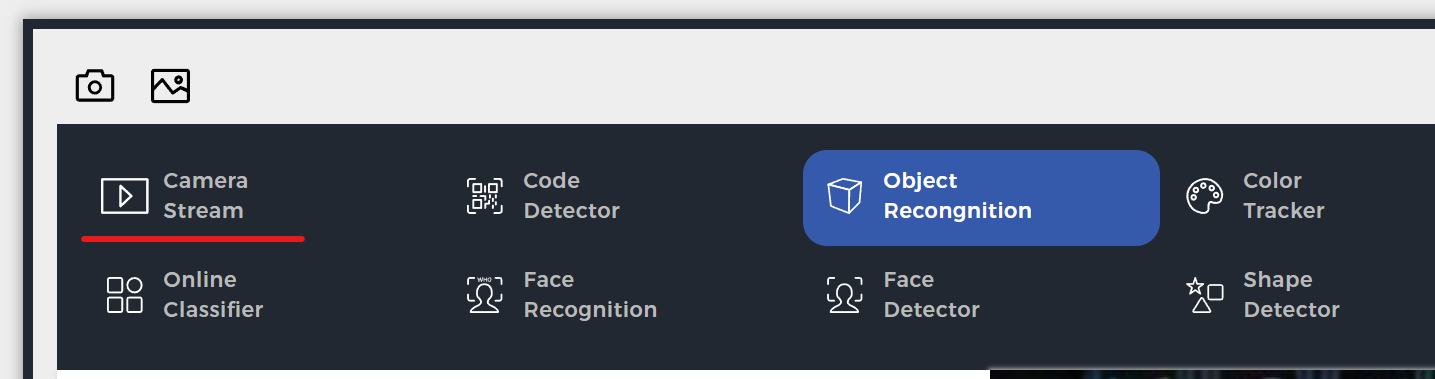
```
2.9 align image as well as You can
```
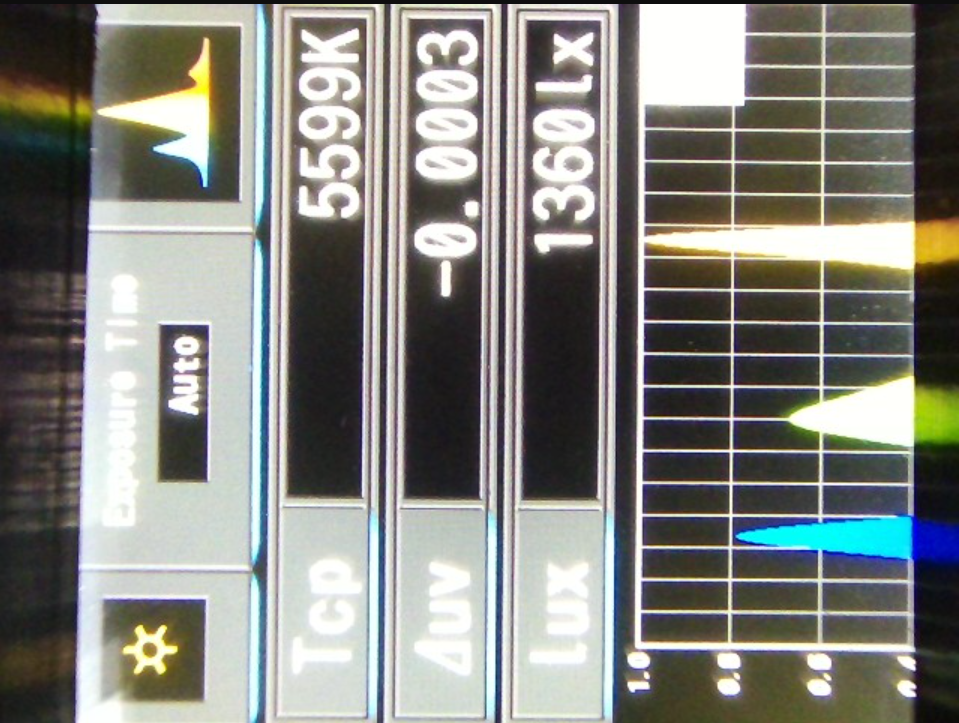
 - [ ] Jupyter-lab notebook for the workflow

# Workflow

1. Setup

    1.1 Init lamp

    1.2 Set Brightness, Color and dUV areas

    1.3 [Optional] load base calibartion

2. Calibrate - either one or more points

3. [Optional] Custom Calibration

4. Create Arduino var

5. Write the calibration to keep a copy

## 1. Setup
This section load python objects and variables please check the ```cam``` variable

### 1.1 Load python objects
Loads ```scope``` and ```lamp``` python objects for reading sekonic and communication with the lamp

In [1]:
cam = "http://192.168.2.224/video_feed"
whiteTreshold = 220

%run calibration_setup.ipynb

### 1.2 Connect to lamp
Lamp needs to be closed before it can be opened again.
If you dont know the serial port where the lamp is connected use the Find COM port section
1st You need to setup sekonic and feedback camera (the areas where the data will be read, 1st -green value is set up so it would be possibel to get dUV - sign location), then close the lamp and start again with the scope objects

In [2]:
lamp1 = apollo_device(ComPort='COM6')
lamp1.getId()
lamp1.macId

'3ffc610c'

In [3]:
lamp1.color = [200,50,50,500,0]
lamp1.update()

#### [Optional] Find COM port

In [9]:
# Get COM port list
import serial.tools.list_ports

com_ports = list(serial.tools.list_ports.comports())

for port, desc, hwid in com_ports:
    print(str(port)+" "+str(desc))

COM5 USB Serial Port (COM5)
COM6 USB Serial Port (COM6)


### 1.3 Set Sekonic camera areas
Set the area where to "read" the Tcp, dUV and lux variables
Once the object is initalized tune the paramters and test by ```update()```
To save the paramteres use the Setup below to generate the ```saved_string``` and copy and paste it into funtion paramter and save the workbook

In [4]:
Brightness = scope(saved_string="self.slider_h.value = (259, 418)\nself.slider_v.value = (409, 459)\nself.minus_comp.value = False\nself.offset_x.value = 0\nself.offset_y.value = 0\nself.replacement_list.value =str([('o', '0'), ('O', '0'), (',', '.')]) \n")

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Label(value='Out:')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x87\x00\x00\x002\x08\x02\x00\x00\x00\xf9\x82_\x9…

Output()

In [5]:
Brightness.update()

3670

In [6]:
dUV = scope(saved_string="self.slider_h.value = (268, 470)\nself.slider_v.value = (318, 382)\nself.minus_comp.value = True\nself.offset_x.value = -80\nself.offset_y.value = 2\nself.replacement_list.value =str([('o', '0'), ('O', '0'), (',', '.'), ('20.0', '0,0')]) \n")

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Label(value='Out:')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x87\x00\x00\x002\x08\x02\x00\x00\x00\xf9\x82_\x9…

Output()

In [7]:
dUV.update()

-0.022

In [8]:
Kelvin = scope(saved_string="self.slider_h.value = (282, 440)\nself.slider_v.value = (248, 298)\nself.minus_comp.value = False\nself.offset_x.value = 0\nself.offset_y.value = 0\nself.replacement_list.value =str([('o', '0'), ('O', '0'), (',', '.'), ('G', '6')]) \n")

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Label(value='Out:')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x87\x00\x00\x002\x08\x02\x00\x00\x00\xf9\x82_\x9…

Output()

In [10]:
Kelvin.update()

5560

In [11]:
lamp1.close()

In [12]:
lamp1 = apollo_device(ComPort='COM6',SekBrightnes=Brightness, SekDuv=dUV, SekKelvin=Kelvin)
lamp1.getId()
lamp1.macId

'3ffc610c'

#### Setup

In [ ]:
Brightness.save_string()

In [ ]:
dUV.save_string()

In [ ]:
Kelvin.save_string()

### 1.4 Load base calibration
Load the starting point where to start generating the new LUT

In [13]:
override_id = None # for ex. 188, but other lamp mac will do as well
# Input the lamp ID
if override_id == None:
    lamp_id_input = lamp1.macId
else:
    lamp_id_input = override_id

file_contents = open_latest_file(lamp_id_input)

if file_contents is not None:
    calibration_points = eval(file_contents)

Opened the latest file for lamp 188: Apollo188_23102023_145839.py


## 2. Calibrate Full
Fully automatic calibration should do all ranges, will try 10 to set all 3 variable and then gives up and saves the latest value, can be run over and over. If the calibartion is good enough only once evry brightness needs to be tested

In [ ]:
# Full Auto calibration
lamp1.color = (calibration_points[0][1][2],
               calibration_points[0][1][3],
               calibration_points[0][1][4],
               calibration_points[0][1][5],
               0)
lamp1.update(debugFlag=True)
time.sleep(20)

# the calibartion loop
for i in range(len(calibration_points)):
    for j in range(len(calibration_points[i])):
        if calibration_points[i][j][1] != 0:
            # set color 1st
            lamp1.color = (calibration_points[i][j][2],
               calibration_points[i][j][3],
               calibration_points[i][j][4],
               calibration_points[i][j][5],
               0
            )
            lamp1.update(debugFlag=True)
            # calibrate
            print("target kelvin: "+str(calibration_points[i][j][0])+" target brightness code: "+str(calibration_points[i][j][1]))
            new_value = calibrateSinglePoint(lamp1, TagetKelvin=calibration_points[i][j][0], TragtBrightnessCode=calibration_points[i][j][1])
            # set new value
            calibration_points[i][j][2] = new_value[0]
            calibration_points[i][j][3] = new_value[1]
            calibration_points[i][j][4] = new_value[2]
            calibration_points[i][j][5] = new_value[3]

                

## 3. [Optional] Custom Range Calibartions
Used for fix existing calibration in only some points, or continu crashed calibration faster

### 3.1 Calibrate WB-WB
In example from 5600K-10 000K would be
```
start = 3
end = 5
```

| # | start / end (Temperature K) |
|---|-----------------------------|
| 0 | 2800                        |
| 1 | 3200                        |
| 2 | 4800                        |
| 3 | 5600                        |
| 4 | 7800                        |
| 5 | 10000                       |

In [ ]:
start = 0
end = 5

# Check that start would be and int from 0-4
# Check that end is int 1-5 while end-start>0

# Full Auto calibration
lamp1.color = (calibration_points[0][1][2],
               calibration_points[0][1][3],
               calibration_points[0][1][4],
               calibration_points[0][1][5],
               0)
lamp1.update(debugFlag=True)
time.sleep(20)

# the calibartion loop
for i in range(len(calibration_points)):
    for j in range(len(calibration_points[i])):
        if calibration_points[i][j][1] != 0:
            # set color 1st
            lamp1.color = (calibration_points[i][j][2],
               calibration_points[i][j][3],
               calibration_points[i][j][4],
               calibration_points[i][j][5],
               0
            )
            lamp1.update(debugFlag=True)
            # calibrate
            print("target kelvin: "+str(calibration_points[i][j][0])+" target brightness code: "+str(calibration_points[i][j][1]))
            new_value = calibrateSinglePoint(lamp1, TagetKelvin=calibration_points[i][j][0], TragtBrightnessCode=calibration_points[i][j][1])
            # set new value
            calibration_points[i][j][2] = new_value[0]
            calibration_points[i][j][3] = new_value[1]
            calibration_points[i][j][4] = new_value[2]
            calibration_points[i][j][5] = new_value[3]

                

### 3.2 Calibrate Single

| # | wb_key (Kelvin) |
|---|-----------------|
| 0 | 2800            |
| 1 | 3200            |
| 2 | 4800            |
| 3 | 5600            |
| 4 | 7800            |
| 5 | 10000           |

| # | brightness_key <4800K (lx) | brightness_key >5600K (lx) |
|---|----------------------------|----------------------------|
| 0 | 0                          | 0                          |
| 1 | 78                         | 157                        |
| 2 | 157                        | 313                        |
| 3 | 313                        | 625                        |
| 4 | 625                        | 1250                       |
| 5 | 1250                       | 2500                       |
| 6 | 2500                       | 5000                       |
| 7 | 5000                       | 10000                      |
| 8 | 10000                      | 20000                      |

In [15]:
wb_key = 1
brightness_key = 6

lamp1.color = (calibration_points[wb_key][brightness_key][2],
               calibration_points[wb_key][brightness_key][3],
               calibration_points[wb_key][brightness_key][4],
               calibration_points[wb_key][brightness_key][5],
               0
            )
lamp1.update()

time.sleep(3)
if brightness_key < 5:
    time.sleep(3)
    
# Single point Calibration
result = tuple(calibration_points[wb_key][brightness_key][2:])
calibrateSinglePoint(lamp1, TagetKelvin=calibration_points[wb_key][brightness_key][0], TragtBrightnessCode=calibration_points[wb_key][brightness_key][1])
calibration_points[wb_key][brightness_key][2] = result[0]
calibration_points[wb_key][brightness_key][3] = result[1]
calibration_points[wb_key][brightness_key][4] = result[2]
calibration_points[wb_key][brightness_key][5] = result[3]

Calibrating for: 3200 brightness id: 6/2500.0lux
kelvin range: 160K dUV range: 0.0005 brightness range: 300lx measuring timeout: 2s
0/10 LUX: 2500.0 - [2519] = -19.0 range(300), skipping
0/10 Tcp: 3200 - 3060 = 140 range(160), skipping
Could not get the entire number from: 0.000
0/10 Could not read dUV
Could not get the entire number from: 0.000
1/10 Could not read dUV
Could not convert value to integer: 027
if this is offending pattern you can add it to the Replacement List
leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 1)
2/10 Could not read dUV
Could not convert value to integer: 09020
if this is offending pattern you can add it to the Replacement List
leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 1)
3/10 Could not read dUV
4/10 dUV: 0.0000 - [ 0.0020] = 0.002 (0.0005) Step: (0, -1, 0, 0, 0) Current RGBW: (364, 167, 2, 139, 0)


KeyboardInterrupt: 

## 4. Generate Arduino var
4.1 Open up the arduino editor and ```src/TempControlled project``` and edit the ```int calibration_points[]``` variable to the output from below
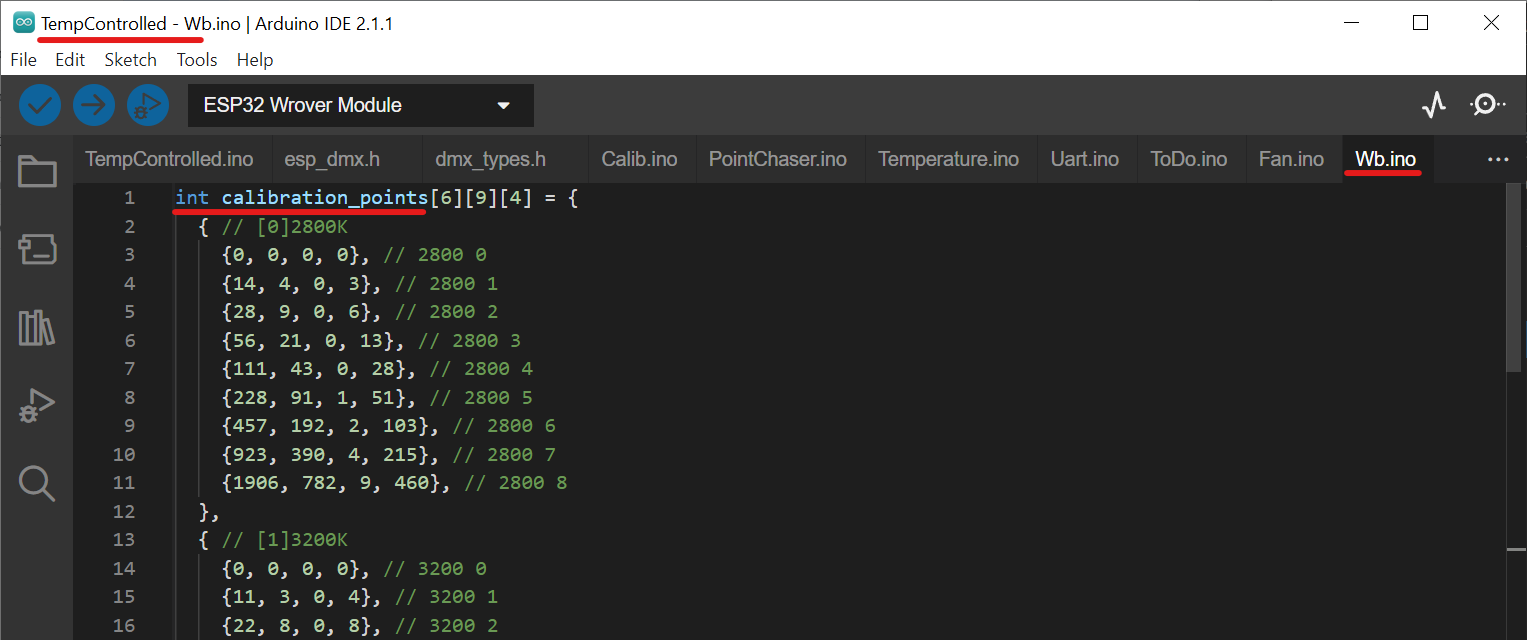

4.2 Rebuild and write the software to the lamp

In [16]:
# Generate Arduino Compatible string
outString = "int calibration_points[6][9][4] = {"

for i in range(6):
    outString += "\n  {{ // [{}]{}K".format(i, calibration_points[i][0][0])
    for j in range(9):
        outString += "\n    {"
        for k in range(4):
            outString += str(calibration_points[i][j][k+2])
            if k < 3:
                outString += ", "
            else:
                outString += "}}, // {} {}".format(calibration_points[i][j][0], j)
    outString += "\n  },"
outString = outString[:-1]
outString += "\n};"

print(outString)


int calibration_points[6][9][4] = {
  { // [0]2800K
    {0, 0, 0, 0}, // 2800 0
    {14, 4, 0, 3}, // 2800 1
    {28, 10, 0, 6}, // 2800 2
    {56, 22, 0, 13}, // 2800 3
    {113, 44, 0, 26}, // 2800 4
    {228, 94, 1, 51}, // 2800 5
    {457, 195, 2, 103}, // 2800 6
    {915, 390, 4, 207}, // 2800 7
    {1901, 731, 9, 409}, // 2800 8
  },
  { // [1]3200K
    {0, 0, 0, 0}, // 3200 0
    {11, 3, 0, 4}, // 3200 1
    {22, 8, 0, 8}, // 3200 2
    {45, 19, 0, 17}, // 3200 3
    {90, 39, 0, 35}, // 3200 4
    {182, 83, 1, 69}, // 3200 5
    {364, 168, 2, 139}, // 3200 6
    {729, 336, 4, 278}, // 3200 7
    {1458, 668, 9, 556}, // 3200 8
  },
  { // [2]4800K
    {0, 0, 0, 0}, // 4800 0
    {9, 2, 0, 17}, // 4800 1
    {18, 8, 0, 34}, // 4800 2
    {37, 19, 1, 68}, // 4800 3
    {75, 41, 3, 136}, // 4800 4
    {151, 89, 6, 273}, // 4800 5
    {330, 201, 13, 519}, // 4800 6
    {665, 409, 27, 1035}, // 4800 7
    {1720, 894, 78, 1801}, // 4800 8
  },
  { // [3]5600K
    {0, 0, 0, 0}, // 5600 

## 5. Save Calibration copy

In [17]:
# Export calibration to text file
import datetime
lampId = lamp1.macId


# Specify the file path (replace 'your_file.txt' with the desired file name and path)
file_path = "Apollo"+str(lampId)+"_"+datetime.datetime.now().strftime("%d%m%Y_%H%M%S")+".py"

# Open the file in write mode ('w')
with open(file_path, 'w') as file:
    # Write the string to the file
    file.write(str(calibration_points))